<a href="https://colab.research.google.com/github/JaimeRedondo/Mushrooms_Classification/blob/master/Mushrooms_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries Import

In [1]:
### If the first time you have an error, try to restart runtime and run again.

### Working with images
! pip install opencv-python
from matplotlib import image
from matplotlib import pyplot
from skimage import io
import cv2
import os
import skimage
from skimage import data, io, filters, transform

### Web scraping packages
from bs4 import BeautifulSoup
import requests
import itertools
from urllib.request import Request, urlopen
import urllib.request

### Pandas/numpy for data manipulation
import pandas as pd
import numpy as np
from urllib.request import urlopen

### Progress bar
from tqdm.notebook import tqdm
from time import sleep 

### Visualize data
%pylab inline
plt.style.use('seaborn-talk')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

### Deep learning libraries
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.metrics import confusion_matrix

### Random
import random 

### Streamlit Web App
! pip install streamlit
! pip install pyngrok
from pyngrok import ngrok
import streamlit as st




Populating the interactive namespace from numpy and matplotlib


## Getting the data

In [2]:
### If you want to scrape mushrooms since the beginning, first of all put the script Scraping_Mushrooms.ipynb in this script , you will have the opportunity
### in the next cell, upload scraping mushrooms to this sesion, after this the script will run and you are going to need to give the parameters you want for 
### the search.

### If you don´t want to scrape mushrooms, you have the data I used in the repo, you will need only to choose the option Use_data and you will get the data

print("Do you want to scrape your own mushrooms or use the data existing?, put Scrape_mushrooms or Use_data")

def scrape_mushrooms(option=input()):
  
  if option == 'Scrape_mushrooms':
    from google.colab import files
    uploaded = files.upload()
    %run Scraping_Mushrooms.ipynb
    return None

  elif option == 'Use_data':
    print('Get the data existing and put it in this directory, later read it')
    print('if you prefer to put in other route you only need to change the main route to after read the data')
    from google.colab import drive
    drive.mount('/content/gdrive')

    path_output_1 = '/content/gdrive/MyDrive/Mushrooms_Classification_Guadalajara'
    ########### Change to the path you save your data!!!!!!!! ##############

    return path_output_1

  else:
    print('The option must be Scrape_mushrooms or Use_data, please, try again:')
    return scrape_mushrooms(option=input())

main_route = scrape_mushrooms()

if main_route == None:
  main_route = path_output
else:
  main_route = scrape_mushrooms()

Do you want to scrape your own mushrooms or use the data existing?, put Scrape_mushrooms or Use_data
Scrape_mushrooms


Saving Scraping_Mushrooms.ipynb to Scraping_Mushrooms.ipynb


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
Choose between All the regions or only Guadalajara Mushrooms
Guadalajara
You choose Guadalajara Mushrooms
Where do you want to save the photos?, example: /home/dsc/FP_Mushrooms/Mushrooms_Classification_Guadalajara
If you want your current path write 'Default'
Default
How many images per mushroom do you want? minimum 20, give a number multiple of 20 (20,40,60...)
20


Lactarius controversus folder already created



## Getting the list with the mushrooms names (the folders names).

In [3]:
### defining the main route (depends on what did you choose before).
### with the data you have already choose

mushrooms_directory=[]
for folder in tqdm(os.listdir(main_route)):
    if '.' in folder:
        pass
    else:
        mushrooms_directory.append(folder)
        
mushrooms_directory=sorted(mushrooms_directory)

### Now you have a directory named mushrooms_directory that is a list of the mushroom names

### Delete the names in the mushrooms_directory list that are not mushroom names

if 'sample_data' in mushrooms_directory:
  mushrooms_directory.remove("sample_data") 

if 'gdrive' in mushrooms_directory:
  mushrooms_directory.remove("gdrive") 

if 'ngrok' in mushrooms_directory:
  mushrooms_directory.remove("ngrok") 

### Getting the number of photos per mushroom we have, we did this to have the maximum length because in some mushrooms can be problems, so
### we won´t have all the images for that mushroom, so now with this maximum length we have the number of images should be per mushroom

lengths=[]
for name in mushrooms_directory:
  lengths.append(len(os.listdir(main_route +'/'+ name +'/')))

number_of_photos = max(lengths)

## Pipeline with the process per image (Resize, Data Augmentation, Staandarize pixels)

In [4]:
### Resize each image shape in 28x28 and print what photos are not available

def resize_photos(directory,main_route,size_photo,number_of_photos):
    for folder in tqdm(directory):
        for numero in range(number_of_photos):
            try:
                route = main_route +'/'+ folder +'/'+ str(numero) + '.jpg'
                data_picture = io.imread(route)
                data_picture = cv2.resize(data_picture, size_photo)
                # save the images
                cv2.imwrite(route,data_picture)
            except:  
                print("Image number "+str(numero)+' of mushroom '+folder+' is not available')

### Standarize 0 - 255 pixels to 0 - 1 and do Data Augmentation to increase the dataset

lista=[]
lista1=[]
def standarize_pixels_and_augmentation(directory,main_route,size_photo,number_of_photos):
    for folder in tqdm(directory):
        for numero in range(number_of_photos):
            try:
                route = main_route +'/'+folder +'/'+ str(numero) + '.jpg'
                image_rgb=io.imread(route)/255.0

                ############### DATA AUGMENTATION ###############

                ### Mirror with vertical line on right
                flip_1 = np.fliplr(image_rgb)

                ### rotation of 90, 180 and 270 grades
                rot_90 = tf.image.rot90(image_rgb, k=1)
                rot_180 = tf.image.rot90(image_rgb, k=2)
                rot_270 = tf.image.rot90(image_rgb, k=3)

                ### Crop the images, can be any size of crop we choose
                height, width = image_rgb.shape[0:2]
                startRow = int(height*.15)
                startCol = int(width*.15)
                endRow = int(height*.85)
                endCol = int(width*.85)
                croppedImage = image_rgb[startRow:endRow, startCol:endCol]
                croppedImage = cv2.resize(croppedImage,size_photo)

                ### Adding contrast
                contrast_img = cv2.addWeighted(image_rgb, 1.5, np.zeros(image_rgb.shape, image_rgb.dtype), 0, 0)

                ### 50% blur by taking the median of the pixels
                blur_image = cv2.medianBlur(image_rgb,1)

                ### Add to dataset
                lista.append(image_rgb)
                lista.append(flip_1)
                lista.append(rot_90)
                lista.append(rot_180)
                lista.append(rot_270)
                lista.append(croppedImage)
                lista.append(contrast_img)
                lista.append(blur_image)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)            

            except:
              print("there are some problems with one of the mushrooms...")

### Group the functions in other function

def standarize_photos(directory,main_route,size_photo,number_of_photos):
    print("reshaping pictures...")
    resize_photos(directory,main_route,size_photo,number_of_photos)
    resize_photos(directory,main_route,size_photo,number_of_photos)
    print("Normalizing pixels...")
    standarize_pixels_and_augmentation(directory,main_route,size_photo,number_of_photos) 

## Give parameters and apply the function defined


In [5]:
### Parameters for the function defined before, the main_route and number_of_photos were defined before.

directory = mushrooms_directory
size_photo = (28,28)

### Applying the group function we defined

standarize_photos(directory,main_route,size_photo,number_of_photos)

reshaping pictures...



Normalizing pixels...


there are some problems with one of the mushrooms...



## Train, validation and tests datasets of images and labels

In [6]:
### Images and labels datasets

images = np.array(lista)
labels = np.array(lista1)

### Splitting the test and train data

randomizado = np.array(range(0,len(images)))
enteros_aleatorios = randint(0,len(images),int(len(images)*0.10))

mask = pd.Series(randomizado).isin(enteros_aleatorios)

test_images = images[mask]
test_labels = labels[mask]
trainval_images = images[~mask]
trainval_labels = labels[~mask]

### Splitting the train data in train and validation

randomizado1 = np.array(range(0,len(trainval_images)))
enteros_aleatorios1 = randint(0,len(trainval_images),int(len(trainval_images)*0.10))

mask1 = pd.Series(randomizado1).isin(enteros_aleatorios1)

validation_images = trainval_images[mask1]
validation_labels = trainval_labels[mask1]
train_images = trainval_images[~mask1]
train_labels = trainval_labels[~mask1]

## Seeing the dataset images

In [7]:

### To see mushrooms when I want
def plot_mushroom_image(N, imgs, labels):
    print(labels[N])
    plt.imshow(imgs[N,], cmap=plt.cm.binary)
    plt.grid(True)

2021-05-09 00:21:36.000 WARNING matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Amanita muscaria


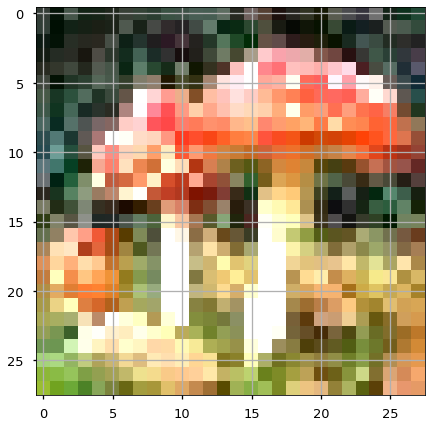

In [8]:
### This is the function defined above to see mushrooms I want
plot_mushroom_image(939,train_images,train_labels)

## One Hot Encoding

In [9]:
### One Hot Encoding for train, test and validation

ohetrain = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotTrain = ohetrain.fit_transform(le.fit_transform(train_labels).reshape(-1, 1))

ohetest = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotTest = ohetest.fit_transform(le.fit_transform(test_labels).reshape(-1, 1))

oheval = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotVal = oheval.fit_transform(le.fit_transform(validation_labels).reshape(-1, 1))

## CNN (Convolutional Neural Network)

In [14]:
### We defined the parameters to use in the neural network, INIT_LR: the learning rate to apply SGD (Stochastic Gradient Descent), epochs, batch size
### and nClasses (How many classes are).

INIT_LR = 1e-3
epochs = 200
batch_size = 32
nClasses = len(mushrooms_directory)

### Define the model with layers, ending with a softmax because we have multiple classes.

def cnn_model():
  model = Sequential()

  model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,3)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
  model.add(MaxPool2D(pool_size=(3,3)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
  model.add(MaxPool2D(pool_size=(3,3)))
  model.add(Dropout(0.25))

  
  model.add(Flatten())

  model.add(Dense(200, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(nClasses, activation='softmax'))

  ### Resume of the model
  
  model.summary()

  return model
  
model = cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0

In [ ]:
### Adam optimizer

model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(),metrics=['categorical_accuracy'])

In [15]:
#### SGD Optimizer

model.compile(optimizer=optimizers.SGD(lr=0.01),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [16]:
### Train the model

h = model.fit(train_images,OneHotTrain, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(validation_images,OneHotVal))


Epoch 1/200
197/197 [==============================] - 34s 6ms/step - loss: 3.8776 - categorical_accuracy: 0.0252 - val_loss: 3.8678 - val_categorical_accuracy: 0.0245
Epoch 2/200
197/197 [==============================] - 1s 4ms/step - loss: 3.8671 - categorical_accuracy: 0.0256 - val_loss: 3.8671 - val_categorical_accuracy: 0.0230
Epoch 3/200
197/197 [==============================] - 1s 4ms/step - loss: 3.8659 - categorical_accuracy: 0.0271 - val_loss: 3.8616 - val_categorical_accuracy: 0.0245
Epoch 4/200
197/197 [==============================] - 1s 4ms/step - loss: 3.8592 - categorical_accuracy: 0.0278 - val_loss: 3.8545 - val_categorical_accuracy: 0.0199
Epoch 5/200
197/197 [==============================] - 1s 4ms/step - loss: 3.8472 - categorical_accuracy: 0.0300 - val_loss: 3.8394 - val_categorical_accuracy: 0.0291
Epoch 6/200
197/197 [==============================] - 1s 4ms/step - loss: 3.8297 - categorical_accuracy: 0.0311 - val_loss: 3.8151 - val_categorical_accuracy: 0.03

### Evaluate model



####Plotting function to see test and validation accuracy


In [17]:
### To plot test,train,and validation accuracy metrics.

def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show() 

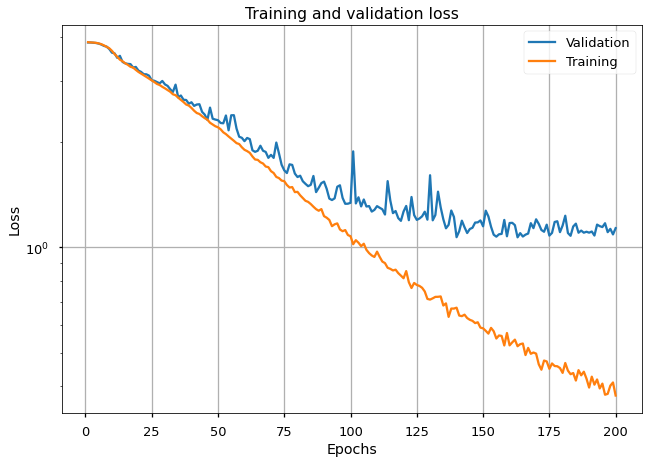

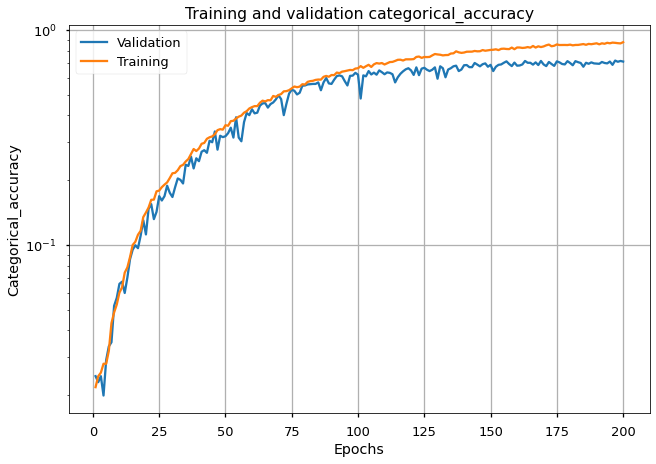

In [18]:
### Graphics to see the possible overfitting during training

plot_metric(h,'loss')
plot_metric(h,'categorical_accuracy')

In [19]:
### Evaluate the accuracy of model. 

model.evaluate(test_images,OneHotTest)

23/23 [==============================] - 0s 5ms/step - loss: 1.0617 - categorical_accuracy: 0.7184


[1.0617307424545288, 0.718406617641449]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


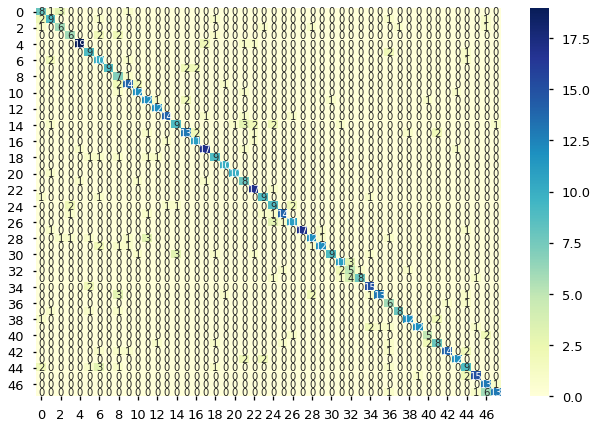

In [21]:
### Get predictions 
predictions = model.predict_classes(test_images)

### Create dictionary to pass the predictions to names
l1 = list(range(len(mushrooms_directory)))
l2 = list(np.unique(labels))
d = dict(zip(l1,l2))

### Get predictions in name format
predictions_labels=[]
for i in predictions:
  predictions_labels.append(d[i])

### Confusion matrix
cm = confusion_matrix(test_labels,predictions_labels,l2)
sns.heatmap(cm,annot=True,cmap="YlGnBu")

## Save objects to keep and load in the Streamlit App

In [22]:
### Save the model 
model.save("model_mushrooms_SGD.h5")

### Save the mushroom labels list
pd.Series(l2).to_csv('mushrooms_labels.csv',sep='|')

## Get the 3 mushrooms more similar to the one we choose

In [23]:
### Doing random predictions, this time for mushroom in the position 189 in test_images

y_pred = model.predict_proba(test_images)
df = pd.DataFrame(y_pred[189], columns = ['probabilities'])
df['labels']=l2
df_sort = df.sort_values('probabilities',ascending = False)[0:3]
df_sort=df_sort.reset_index(drop=True)
df_sort

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


,probabilities,labels
0,0.991433,Boletus erythropus
1,0.003422,Boletus edulis
2,0.001918,Amanita pantherina


# Streamlit

## Installing Ngrok for Streamlit

In [24]:
### Import the zipfile ngrok-stable-inux-amd64.zip, is neccesary for installation
from google.colab import files
uploaded = files.upload()

### Unzip the zipfile
!unzip /content/ngrok-stable-linux-amd64.zip

### Authentication
!ngrok authtoken 1s4dWx40WEPgxZOREhcu4JZc5JL_79bCSDk2c3hVJ38GTc2zz

### Public url with port 80, to have access to the app
public_url = ngrok.connect(port = '80')

Saving ngrok-stable-linux-amd64.zip to ngrok-stable-linux-amd64.zip
Archive:  /content/ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


2021-05-09 00:32:07.719 INFO    pyngrok.ngrok: Opening tunnel named: http-80-46e1d8b7-5e0c-4800-9260-34661610eab7
2021-05-09 00:32:07.787 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="no configuration paths supplied"
2021-05-09 00:32:07.793 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2021-05-09 00:32:07.795 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2021-05-09 00:32:07.798 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040
2021-05-09 00:32:07.862 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="tunnel session started" obj=tunnels.session
2021-05-09 00:32:07.866 INFO    pyngrok.process.ngrok: t=2021-05-09T00:32:07+0000 lvl=info msg="client session established" obj=csess id=faef5c538f91
2

## Streamlit App


In [25]:
%%writefile app.py

### IMPORT LIBRARIES

### Streamlit
import streamlit as st
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

### Images
from matplotlib import image
from matplotlib import pyplot
from skimage import io
import cv2
import os
import skimage
from skimage import data, io, filters, transform
import numpy as np

### Load model
from keras.models import load_model

### Deep Learning
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
import tensorflow as tf

### Random
import random 

### Web scraping packages
from bs4 import BeautifulSoup
import requests
import itertools
from urllib.request import Request, urlopen
import urllib.request

### Title, subheader and first paragraphs
st.title('Mushrooms Classification')
st.subheader('App to know what mushroom is your picture')
st.markdown("Hello everybody and welcome to this interactive website on **mushrooms classification**.")
st.markdown("This work consists on classifying different types of mushrooms from images, using the famous convolutional neural networks (CNN) as a method.")
st.markdown("Put a mushroom and get the probability that it is a type of mushroom among the different species studied, and you will also get the 3 most likely mushrooms it is.")
st.markdown("Please, put a picture of your choice")

### Load the model saved before.
model = load_model('model_mushrooms_SGD.h5')

### Read the mushrooms_labels.csv
l2 = pd.read_csv('mushrooms_labels.csv',sep='|')
l2 = l2['0'].to_list()

### Programming the App
try:

  ### Charge the picture of your choice
  picture = st.file_uploader('picture',type='jpg')

  ### Display the picture chosen in the app
  st.image(picture)

  ### Standarize pixels
  image_rgb=io.imread(picture)/255.0

  ### Resize photo, this time (28,28)
  data_picture = cv2.resize(image_rgb, (28, 28))

  ### Predict which mushroom is in the picture and giving the 3 more similar to it.
  pictures = np.array([data_picture])
  pred_photos = model.predict_proba(pictures)
  df = pd.DataFrame(pred_photos[0], columns = ['probabilities'])
  df['labels']=l2
  df_sort = df.sort_values('probabilities',ascending = False)[0:3]
  X=df_sort['probabilities']
  Y=df_sort['labels'] 

  ### Barplot with the information about the 3 mushrooms more similar to the one in the photo
  fig = plt.figure(figsize=(12, 8))
  plt.bar(range(len(X)), X)
  plt.xticks(np.arange(len(X)), Y)
  plt.ylabel('probability')
  ax = X.plot(kind='bar')
  ax.set_xticklabels(Y)
  rects = ax.patches
  for rect, label in zip(rects, X):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 10, height+0.01, label,
              ha='left', va='bottom')
  st.pyplot(fig)

  ### Text with the percentage of accuracy and the mushroom more similar to the one in the photo
  probability = str(round(df_sort['probabilities'][:-2]*100,2).reset_index()['probabilities'][0])
  label = df_sort['labels'][:-2].reset_index()['labels'][0]
  text = f"Your choice has **{probability} %** to be **{label}** mushroom"
  st.markdown(text)

  ### Show pictures similars to the one that the model thinks is in the photo
  st.markdown("Here, you have other different pictures of this mushroom")
  
  url = 'https://www.google.com/search?q='+label+'&tbm=isch&hl=es&sa=X&ved=2ahUKEwjw_M7z2NfuAhUMpRoKHbPQAokQgowBegQIARAX&biw=1905&bih=852'
  response = requests.get(url)
  soup = BeautifulSoup(response.content,'html.parser')
  images = soup.find_all("img")         
  images = images[1::]
  random_photos = random.sample(images, 8)

  urls_list = []
  for image in random_photos:
    image_src = image['src']
    urls_list.append(image_src)

  st.image(urls_list)

except:
  pass

Writing app.py


In [26]:
### run the app in the server
!streamlit run --server.port 80 app.py&>/dev/null&

### Access to the app
public_url

<NgrokTunnel: "http://6aa6462713dd.ngrok.io" -> "http://localhost:80">